In [1]:
import pandas as pd
import numpy as np
import torch
import time
# import gpytorch
import os
os.chdir("/Users/mohdzaki/Downloads")
import warnings
warnings.filterwarnings("ignore")
# from new_plot import *
from plot import *
set_things()
import_path = "/Users/mohdzaki/Documents/GitHub/machine_learning_glass/Deep_Learning_Aided_Rational_Design_of_Oxide_Glasses"
os.chdir(import_path)

from sklearn.model_selection import train_test_split
import shap

In [2]:
from dropout_norm import DropoutNormNet, split, DoML
os.chdir("/Users/mohdzaki/Downloads")
from torch import nn
import matplotlib.pyplot as plt
import datetime
from sklearn.metrics import r2_score
import pickle
from sklearn.model_selection import KFold

In [3]:
def myloss(y,ypred):
    return ((y-ypred)**2).sum(axis=0)/y.shape[0]

os.chdir("/Users/mohdzaki/Downloads/nd")
with open('nd_drop_final_report.pickle','rb') as f:
    op = pickle.load(f)
op = op[1:]
    
os.chdir("/Users/mohdzaki/Downloads/Vd")
with open('Vd_drop_final_report_.pickle','rb') as f:
    op1 = pickle.load(f)
op1 = op1[1:]

os.chdir("/Users/mohdzaki/Downloads/")

In [4]:
for mnd,mvd in zip(op[0][:4],op1[0][:4]):
    print(mnd.R2_train.round(2),mnd.R2_val.round(2), mvd.R2_train.round(2),mvd.R2_val.round(2))

0.98 0.97 0.97 0.97
0.98 0.98 0.96 0.95
0.98 0.97 0.96 0.96
0.98 0.97 0.97 0.96


In [51]:
model_vd

DropoutNormNet(
  (seq): Sequential(
    (L0): Linear(in_features=47, out_features=19, bias=True)
    (D0): Dropout(p=0.2, inplace=False)
    (A0): ReLU()
    (L1): Linear(in_features=19, out_features=19, bias=True)
    (D1): Dropout(p=0.2, inplace=False)
    (A1): ReLU()
    (LN): Linear(in_features=19, out_features=1, bias=True)
  )
)

In [5]:
model_nd = op[0][1].model
model_vd = op1[0][0].model

In [6]:
vds = pd.read_csv('Vd/Vd_oxides.csv')
xvds = torch.tensor(vds[vds.columns[:-1]].values).float()

mean_xvds = xvds.mean(dim=0, keepdim=True)
stds_xvds = xvds.std(dim=0, keepdim=True)
mask_xvds = stds_xvds<=0.0001
stds_xvds[mask_xvds] = 1
#         norm_xn = (xn - op[0][1].means[0][:-1])/op[0][1].stds[0][:-1]
norm_xvds = (xvds - mean_xvds)/stds_xvds
vd = ((model_vd(norm_xvds).detach().numpy())*op1[0][0].stds[0][-1].numpy() + op1[0][0].means[0][-1].numpy()).ravel()
vds_p = vds.copy()
vds['Vd'] = vd

nds = pd.read_csv('nd/nd_oxides.csv')
xnds = torch.tensor(nds[nds.columns[:-1]].values).float()
mean_xnds = xnds.mean(dim=0, keepdim=True)
stds_xnds = xnds.std(dim=0, keepdim=True)
mask_xnds = stds_xnds<=0.0001
stds_xnds[mask_xnds] = 1
#         norm_xn = (xn - op[0][1].means[0][:-1])/op[0][1].stds[0][:-1]
norm_xnds = (xnds - mean_xnds)/stds_xnds
nd = ((model_nd(norm_xnds).detach().numpy())*op[0][1].stds[0][-1].numpy() + op[0][1].means[0][-1].numpy()).ravel()
nds_p = nds.copy()
nds['nd'] = nd

In [7]:
model_nd = op[0][1].model
stds_nd  = op[0][1].stds[0][-1].numpy()
mean_nd  = op[0][1].means[0][-1].numpy()
xmean_nd = op[0][1].means[0][:-1].numpy()
xstds_nd  = op[0][1].stds[0][:-1].numpy()

model_vd = op1[0][0].model
stds_vd = op1[0][0].stds[0][-1].numpy()
mean_vd = op1[0][0].means[0][-1].numpy()
xstds_vd = op1[0][0].stds[0][:-1].numpy()
xmean_vd = op1[0][0].means[0][:-1].numpy()

rs = 2

In [43]:
def fullSHAP(model,stds,means,data,rs,propert):
    propert  = data.columns[-1]
    column_list = list(data.columns[:-1])
    new_data = data.copy()
    import shap
    shap.initjs()
    xnds = torch.tensor(new_data[new_data.columns[:-1]].values).float()
    mean_xnds = xnds.mean(dim=0, keepdim=True)
    stds_xnds = xnds.std(dim=0, keepdim=True)
    mask_xnds = stds_xnds<=0.0001
    stds_xnds[mask_xnds] = 1
    norm_xnds = (xnds - mean_xnds)/stds_xnds
    nd = ((model(norm_xnds).detach().numpy())*stds + means).ravel()
    nds_p = nds.copy()
    new_data[propert] = nd
    
    yshap = nd.copy()
    yshap = (torch.tensor(yshap) - means)/stds
    siz = 300
    X_train, X_test, y_train, y_test = train_test_split(norm_xnds.detach().numpy(),yshap.detach().numpy(),test_size=siz,random_state=rs)
#     try:
#         os.chdir('/Users/mohdzaki/Downloads/')
#         os.mkdir('SHAP_solo_bar')
#         os.chdir('/Users/mohdzaki/Downloads/SHAP_solo_bar')
#         print('Directory created')
#     except:
#         os.chdir('/Users/mohdzaki/Downloads/SHAP_solo_bar')
#         print('Directory already exists')
    t1 = time.time()
#     explainer = shap.DeepExplainer(model, norm_xnds)# torch.tensor(X_train[:siz]))
#     explainer = shap.DeepExplainer(model,torch.tensor(X_train[:siz]))
    name1 = propert+'full_explainer.pickle'
    exp_path = os.path.join('./fullSHAP/results',name1)
    explainer = pickle.load(open(exp_path,'rb'))
    t2 = time.time()
    print(t2-t1)
#     shap_values = explainer.shap_values(norm_xnds)#torch.tensor(X_test[:siz]))
#     shap_values = explainer.shap_values(torch.tensor(X_test[:siz]))
    name2 = propert+'full_shap_values.pickle'
    val_path = os.path.join('./fullSHAP/results',name2)
    shap_values = pickle.load(open(val_path,'rb'))
    t3 = time.time()
    print(t3-t1,t2-t1)
    ####
#     shap_values = shap_values*stds + means
#     X_test      = torch.tensor(X_test)*stds_xnds + mean_xnds
#     X_test      = X_test.detach().numpy()
    ####
    
#     X_test     = norm_xnds*stds*xnds + mean_xnds
#     X_test     = X_test.detach().numpy()
    hill_all = []
    for col in data.columns.tolist()[:-1]:
        hill = ''
        for ele in col:
            if ele in ['2','3','4','5','6','7','8','9','10','11','12','13']:
                hill = hill + '$_' + ele + '$'
            else:
                hill = hill + ele
#         print(hill)
        hill_all.append(hill)
    
    feat_list = [r'\textbf{{{}}}'.format(val) for val in hill_all]#data.columns[:-1].tolist()]
    feat_list = [r'\textbf{{{}}}'.format(val) for val in data.columns[:-1].tolist()]
    cblabel = r'\textbf{{{}}}'.format('Feature value')
#     feat_list = hill_all#[r'\textbf{{{}}}'.format(val) for val in hill_all]
    feat_list = [r'\textbf{{{}}}'.format(val) for val in hill_all]
#     cblabel = 'Feature value'
    print(type(shap_values),type(stds_xnds),type(mean_xnds))
#     shap_values = shap_values*stds_xnds.detach().numpy()+mean_xnds.detach().numpy()
    shap_values = shap_values*stds
    ax = shap.summary_plot(shap_values, torch.tensor(xnds),feature_names=feat_list,show=False,max_display=25,color_bar=False)#len(data.columns[:-1]))#,plot_type='bar')
    cbar = plt.colorbar(aspect=50)
    cbar.set_label(cblabel)
    cbar.minorticks_off()
    # cbar.ax.set_axis_off()
    midpoint_cbar = (cbar.vmax+cbar.vmin)/2
    cbar.set_ticks([cbar.vmax,midpoint_cbar,cbar.vmin])#,labels=['High','Low'])
    cbar.set_ticklabels([r'\textbf{{{}}}'.format('High'),'',r'\textbf{{{}}}'.format('Low')])
    plt.xlabel('SHAP value')
    
#     ax = shap.summary_plot(shap_values, torch.tensor(norm_xnds.detach().numpy()),feature_names=feat_list,show=False,max_display=25,color_bar_label=r'\textbf{{{}}}'.format('Feature value'))#len(data.columns[:-1]))#,plot_type='bar')
#     ax = shap.summary_plot(shap_values, torch.tensor(X_test),feature_names=feat_list,show=False,max_display=len(feat_list),color_bar_label=r'\textbf{{{}}}'.format('Feature value'),axis_color='#000000')#len(data.columns[:-1]))#,plot_type='bar')
#     plt.title('Summary Plot')

    labx = r'\textbf{{{}}}'.format('SHAP value')
    laby = r'\textbf{{{}}}'.format('Oxides')
    
    plt.xlabel(labx,fontsize=20)
    plt.ylabel(laby,fontsize=20)


#     ax.set_yticklabels(locs,labels2)
    
    print('making 1st plot')
    t4 = time.time()
    plt.savefig(propert+"_local_summary_plot_25.png",dpi=1200,bbox_inches='tight')
    print(os.getcwd())
    plt.show()
#     break
    print('ban gaya')
    t5 = time.time()
    print(t5-t4)
    print('making second plot')
    
#     shap.summary_plot(shap_values, torch.tensor(X_test),feature_names=feat_list,show=False,plot_type='bar',max_display=len(feat_list),axis_color='#000000')#len(data.columns[:-1]))
    shap.summary_plot(shap_values, torch.tensor(norm_xnds.detach().numpy()),feature_names=feat_list,show=False,plot_type='bar',max_display=25)#len(data.columns[:-1]))
    plt.xlabel('mean|SHAP value|')
    labx = r'\textbf{{{}}}'.format('mean($|$SHAP value$|$)')
    laby = r'\textbf{{{}}}'.format('Oxides')
    
    plt.xlabel(labx,fontsize=20)
    plt.ylabel(laby,fontsize=20)
    
    plt.savefig(propert+"_bar_summary_plot_25.png",dpi=1200,bbox_inches='tight')
    t6 = time.time()
    print('ban gaya')
    print(t6-t5)
    plt.show()
    os.chdir('/Users/mohdzaki/Downloads/')
    return explainer, shap_values

In [44]:
# set_font(family='Serif',weight='bold')

In [45]:
# help(plt.colorbar)

In [46]:
# import matplotlib.font_manager
# matplotlib.font_manager._rebuild()


0.00693821907043457
0.017364025115966797 0.00693821907043457
<class 'numpy.ndarray'> <class 'torch.Tensor'> <class 'torch.Tensor'>
making 1st plot
/Users/mohdzaki/Downloads


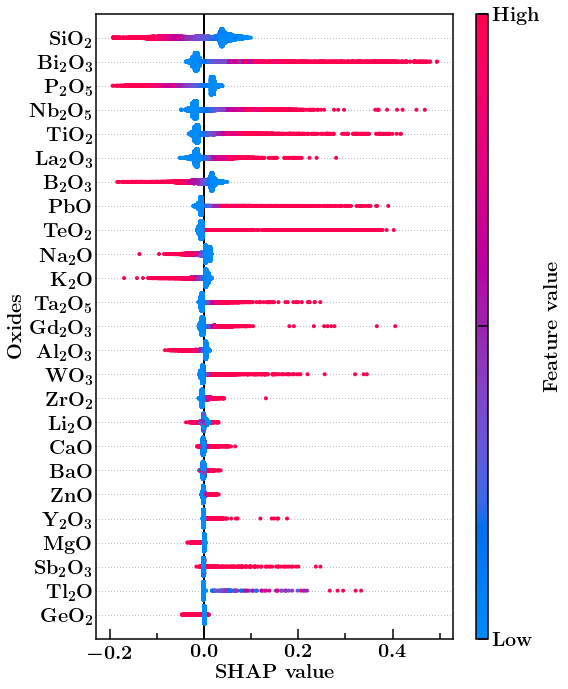

ban gaya
18.835208892822266
making second plot
ban gaya
6.880084991455078


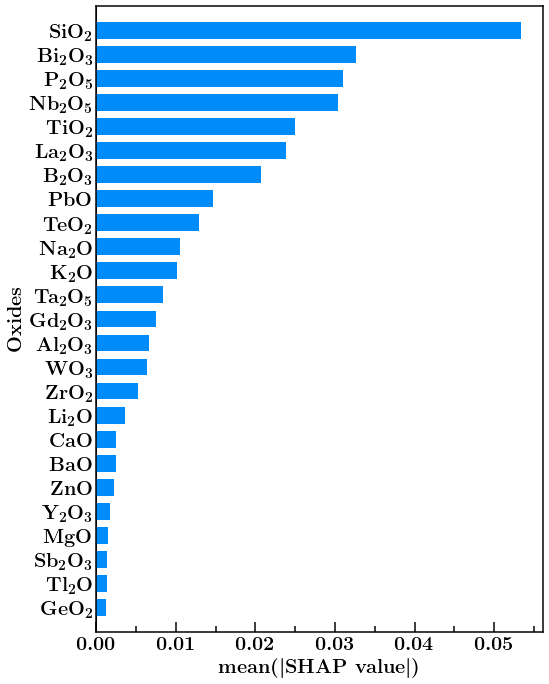

In [47]:
[ex,val] = fullSHAP(model_nd,stds_nd,mean_nd,nds,rs,'nd')

0.0062100887298583984
0.013067007064819336 0.0062100887298583984
<class 'numpy.ndarray'> <class 'torch.Tensor'> <class 'torch.Tensor'>
making 1st plot
/Users/mohdzaki/Downloads


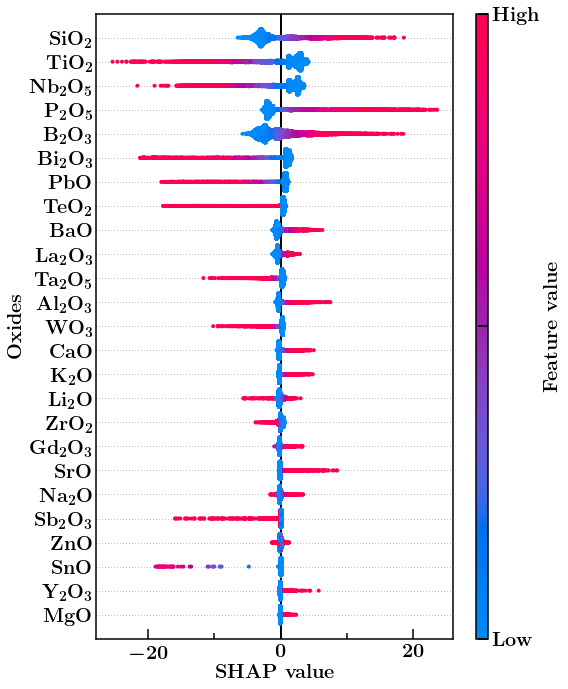

ban gaya
16.588006019592285
making second plot
ban gaya
6.478365182876587


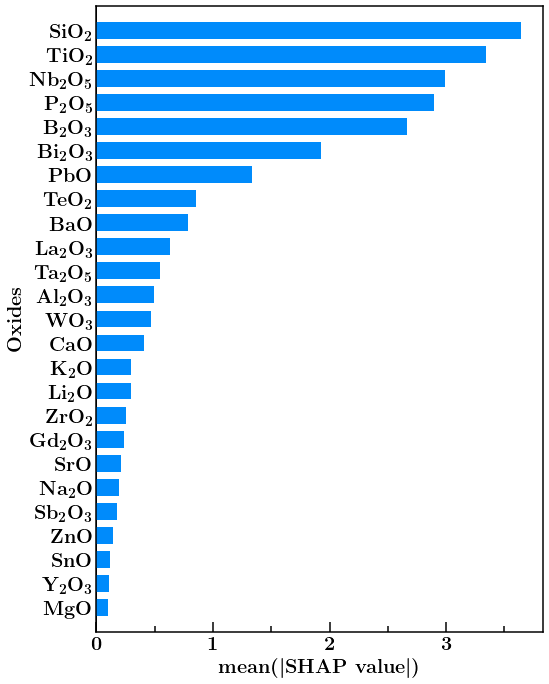

In [48]:
[ex,val] = fullSHAP(model_vd,stds_vd,mean_vd,vds,rs,'Vd')

In [17]:
def smallshap(model,stds,means,data,rs,propert,family_name):
    propert  = data.columns[-1]
    column_list = list(data.columns[:-1])
    new_data = data.copy()
    import shap
    shap.initjs()
    xnds = torch.tensor(new_data[new_data.columns[:-1]].values).float()
    mean_xnds = xnds.mean(dim=0, keepdim=True)
    stds_xnds = xnds.std(dim=0, keepdim=True)
    mask_xnds = stds_xnds<=0.0001
    stds_xnds[mask_xnds] = 1
    norm_xnds = (xnds - mean_xnds)/stds_xnds
    nd = ((model(norm_xnds).detach().numpy())*stds + means).ravel()
    nds_p = nds.copy()
    new_data[propert] = nd
    
    yshap = nd.copy()
    yshap = (torch.tensor(yshap) - means)/stds
#     siz = 300
#     X_train, X_test, y_train, y_test = train_test_split(norm_xnds.detach().numpy(),yshap.detach().numpy(),test_size=siz,random_state=rs)
#     try:
#         os.chdir('/Users/mohdzaki/Downloads/')
#         os.mkdir('SHAP_solo_bar')
#         os.chdir('/Users/mohdzaki/Downloads/SHAP_solo_bar')
#         print('Directory created')
#     except:
#         os.chdir('/Users/mohdzaki/Downloads/SHAP_solo_bar')
#         print('Directory already exists')
    t1 = time.time()
    explainer = shap.DeepExplainer(model, norm_xnds)# torch.tensor(X_train[:siz]))
#     explainer = shap.DeepExplainer(model,torch.tensor(X_train[:siz]))
    
    name1 = propert+family_name+'small_explainer.pickle'
    exp_path = os.path.join('./fullSHAP/results',name1)
    
    pickle.dump(explainer,open(exp_path,'wb'))
#     explainer = pickle.load(open(exp_path,'rb'))
    t2 = time.time()
    print(t2-t1)
    shap_values = explainer.shap_values(norm_xnds)#torch.tensor(X_test[:siz]))
#     shap_values = explainer.shap_values(torch.tensor(X_test[:siz]))
    name2 = propert+family_name+'small_shap_values.pickle'
    val_path = os.path.join('./fullSHAP/results',name2)
    pickle.dump(shap_values,open(val_path,'wb'))
    
#     shap_values = pickle.load(open(val_path,'rb'))
    t3 = time.time()
    print(t3-t1,t2-t1)
    ####
#     shap_values = shap_values*stds + means
#     X_test      = torch.tensor(X_test)*stds_xnds + mean_xnds
#     X_test      = X_test.detach().numpy()
    ####
    
#     X_test     = norm_xnds*stds*xnds + mean_xnds
#     X_test     = X_test.detach().numpy()
    hill_all = []
    for col in data.columns.tolist()[:-1]:
        hill = ''
        for ele in col:
            if ele in ['2','3','4','5','6','7','8','9','10','11','12','13']:
                hill = hill + '$_' + ele + '$'
            else:
                hill = hill + ele
#         print(hill)
        hill_all.append(hill)
    
    feat_list = [r'\textbf{{{}}}'.format(val) for val in hill_all]#data.columns[:-1].tolist()]
#     feat_list = [r'\textbf{{{}}}'.format(val) for val in data.columns[:-1].tolist()]
#     cblabel = r'\textbf{{{}}}'.format('Feature value')
    feat_list = hill_all#[r'\textbf{{{}}}'.format(val) for val in hill_all]
    cblabel = 'Feature value'
    print(type(shap_values),type(stds_xnds),type(mean_xnds))
#     shap_values = shap_values*stds_xnds.detach().numpy()+mean_xnds.detach().numpy()
    shap_values = shap_values*stds
    ax = shap.summary_plot(shap_values, torch.tensor(xnds),feature_names=feat_list,show=False,max_display=25,color_bar=False)#len(data.columns[:-1]))#,plot_type='bar')
    cbar = plt.colorbar(aspect=50)
    cbar.set_label('Feature value')
    cbar.minorticks_off()
    # cbar.ax.set_axis_off()
    midpoint_cbar = (cbar.vmax+cbar.vmin)/2
    cbar.set_ticks([cbar.vmax,midpoint_cbar,cbar.vmin])#,labels=['High','Low'])
    cbar.set_ticklabels(['High','','Low'])
    plt.xlabel('SHAP value')
    
#     ax = shap.summary_plot(shap_values, torch.tensor(norm_xnds.detach().numpy()),feature_names=feat_list,show=False,max_display=25,color_bar_label=r'\textbf{{{}}}'.format('Feature value'))#len(data.columns[:-1]))#,plot_type='bar')
#     ax = shap.summary_plot(shap_values, torch.tensor(X_test),feature_names=feat_list,show=False,max_display=len(feat_list),color_bar_label=r'\textbf{{{}}}'.format('Feature value'),axis_color='#000000')#len(data.columns[:-1]))#,plot_type='bar')
#     plt.title('Summary Plot')

#     labx = r'\textbf{{{}}}'.format('SHAP value')
#     laby = r'\textbf{{{}}}'.format('Oxides')
    
#     plt.xlabel(labx,fontsize=20)
#     plt.ylabel(laby,fontsize=20)


#     ax.set_yticklabels(locs,labels2)
    
    print('making 1st plot')
    t4 = time.time()
#     plt.savefig(propert+"_local_summary_plot_25.png",dpi=1200,bbox_inches='tight')
    print(os.getcwd())
    plt.show()
#     break
    print('ban gaya')
    t5 = time.time()
    print(t5-t4)
    print('making second plot')
    
#     shap.summary_plot(shap_values, torch.tensor(X_test),feature_names=feat_list,show=False,plot_type='bar',max_display=len(feat_list),axis_color='#000000')#len(data.columns[:-1]))
    shap.summary_plot(shap_values, torch.tensor(norm_xnds.detach().numpy()),feature_names=feat_list,show=False,plot_type='bar',max_display=25)#len(data.columns[:-1]))
    plt.xlabel('mean|SHAP value|')
#     labx = r'\textbf{{{}}}'.format('$|$SHAP value$|$')
#     laby = r'\textbf{{{}}}'.format('Oxides')
    
#     plt.xlabel(labx,fontsize=20)
#     plt.ylabel(laby,fontsize=20)
    
#     plt.savefig(propert+"_bar_summary_plot_25.png",dpi=1200,bbox_inches='tight')
    t6 = time.time()
    print('ban gaya')
    print(t6-t5)
    plt.show()
    os.chdir('/Users/mohdzaki/Downloads/')
    return explainer, shap_values

In [31]:
family=['SiO2','Al2O3','B2O3','BaO','Li2O','CaO','Na2O','Sb2O3']
ndss=nds[nds[family].sum(axis=1).between(99,101)]
ndss=ndss[ndss.astype(bool).sum(axis=1)>=5]

1.6207141876220703

0.008558988571166992
1.3746140003204346 0.008558988571166992
<class 'numpy.ndarray'> <class 'torch.Tensor'> <class 'torch.Tensor'>
making 1st plot
/Users/mohdzaki/Downloads


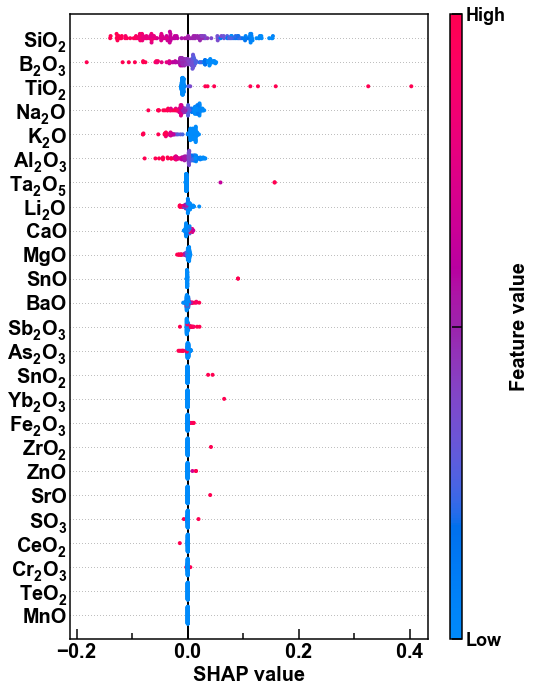

ban gaya
0.7178289890289307
making second plot
ban gaya
0.10303592681884766


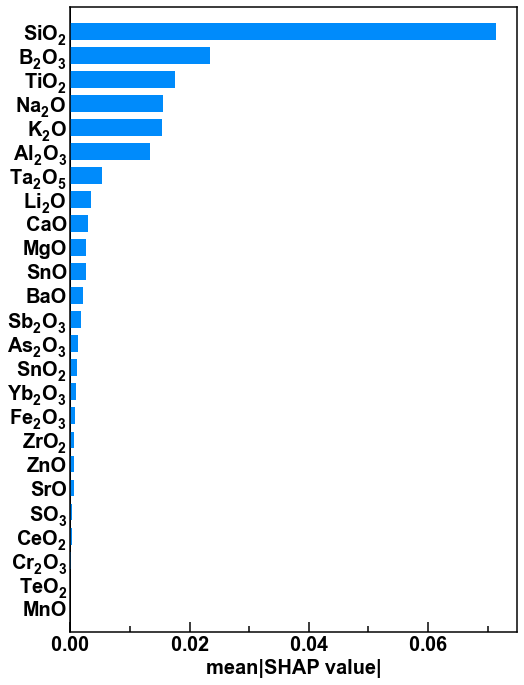

In [29]:
[ex,val] = smallshap(model_nd,stds_nd,mean_nd,ndss,rs,'nd',family_name='fam1_nd')

<h3>predicting optical properties

In [8]:
def predict(model,stds,means,data,rs,propert):
    
    propert  = data.columns[-1]
    column_list = list(data.columns[:-1])
    new_data = data.copy()
    import shap
    shap.initjs()
    xnds = torch.tensor(new_data[new_data.columns[:-1]].values).float()
    mean_xnds = xnds.mean(dim=0, keepdim=True)
    stds_xnds = xnds.std(dim=0, keepdim=True)
    mask_xnds = stds_xnds<=0.0001
    stds_xnds[mask_xnds] = 1
    norm_xnds = (xnds - mean_xnds)/stds_xnds
    nd = ((model(norm_xnds).detach().numpy())*stds + means).ravel()
    nds_p = nds.copy()
    new_data[propert] = nd
    
    yshap = nd.copy()
    yshap = (torch.tensor(yshap) - means)/stds
    predictions = nd
    return predictions

In [10]:
#BaO, B2O3, SiO2 crown glass
#PbO, K2O, SiO2 flint glass

In [59]:
family=['SiO2','B2O3','BaO']
family=['Gd2O3', 'ZnO', 'La2O3', 'ZrO2', 'B2O3']

# values=['80','10','10']
output=['Vd']
dfshowv = vds[vds[family].sum(axis=1).between(99,101)][family+output]
maskv = dfshowv.astype(bool).sum(axis=1)==6
dfshowv[maskv].describe()

,Gd2O3,ZnO,La2O3,ZrO2,B2O3,Vd
count,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000
mean,21.978889,12.525556,28.936667,5.432778,31.126111,50.189529
std,7.614325,3.295305,4.475135,0.942380,2.844783,0.488149
min,3.000000,4.460000,17.430000,4.320000,25.640000,48.970524
25%,18.810000,11.657500,27.050000,4.895000,29.365000,50.046180
50%,21.320000,12.150000,29.450000,5.100000,30.240000,50.277390
75%,22.547500,14.180000,30.760000,5.730000,33.350000,50.439873
max,38.960000,20.000000,40.000000,8.250000,35.720000,51.149746


<H3>Since we have identified the families, we will vary the range of chemical components and find out the property value

In [ ]:
family_list=[['Gd2O3', 'ZnO', 'La2O3', 'ZrO2', 'B2O3']]

In [9]:
family=['SiO2','B2O3','BaO']
family=['Gd2O3', 'ZnO', 'La2O3', 'ZrO2', 'B2O3']

# values=['80','10','10']
output=['nd']
dfshow = nds[nds[family].sum(axis=1).between(99,101)][family+output]
mask = dfshow.astype(bool).sum(axis=1)==6
dfshow[mask]
# .describe()

,Gd2O3,ZnO,La2O3,ZrO2,B2O3,nd
3670,38.96,4.46,26.62,4.32,25.64,1.805743
3717,21.02,16.46,29.45,4.82,28.25,1.763513
3727,21.35,11.77,29.88,8.25,28.75,1.776513
3732,21.59,14.32,30.22,4.83,29.04,1.764076
3738,36.35,11.97,17.43,4.94,29.31,1.778902
3741,29.30,12.06,24.13,4.98,29.53,1.768978
3746,22.15,12.15,30.94,5.01,29.75,1.765352
3747,22.12,12.15,30.96,5.01,29.76,1.765321
3757,3.00,20.00,40.00,7.00,30.00,1.765712
3782,22.68,9.96,31.69,5.19,30.48,1.766593


In [10]:
stats=dfshow[mask].describe()
stats

,Gd2O3,ZnO,La2O3,ZrO2,B2O3,nd
count,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000
mean,21.978889,12.525556,28.936667,5.432778,31.126111,1.762152
std,7.614325,3.295305,4.475135,0.942380,2.844783,0.016028
min,3.000000,4.460000,17.430000,4.320000,25.640000,1.739898
25%,18.810000,11.657500,27.050000,4.895000,29.365000,1.750199
50%,21.320000,12.150000,29.450000,5.100000,30.240000,1.764698
75%,22.547500,14.180000,30.760000,5.730000,33.350000,1.767094
max,38.960000,20.000000,40.000000,8.250000,35.720000,1.805743


In [65]:
family=['B2O3','Gd2O3', 'ZnO', 'La2O3', 'ZrO2']
take_composition = []
for b2o3 in np.arange(25,40,0.5):
    for la2o3 in np.arange(15,45,0.5):
        for gd2o3 in np.arange(3,40,0.5):
            for zno in np.arange(4,25,0.5):
                for zro2 in np.arange(4,10,0.5):
                    if 99.99 <= (b2o3+la2o3+gd2o3+zno+zro2) <= 101:
                        save=[b2o3,la2o3,gd2o3,zno,zro2]
                        take_composition.append(save)

In [69]:
save_name = '_'.join(family)

In [70]:
sample = pd.DataFrame(data=take_composition,columns=family)

In [80]:
synthetic = pd.DataFrame(data=take_composition,columns=family)
mask = synthetic.sum(axis=1)==100
df_synthetic = synthetic[mask]
df_synthetic.shape

(781835, 5)

In [106]:
patentx_nd = pd.concat((pd.DataFrame(columns=nds.columns[:-1]),df_synthetic)).fillna(0)

patentx_vd = pd.concat((pd.DataFrame(columns=vds.columns[:-1]),df_synthetic)).fillna(0)

In [107]:
xn = torch.tensor(patentx_nd.values).float()

mean_xn = xn.mean(dim=0, keepdim=True)
stds_xn = xn.std(dim=0, keepdim=True)
mask_xn = stds_xn<=0.0001
stds_xn[mask_xn] = 1

norm_xn = (xn - mean_xnds)/stds_xnds
nd_patent = ((model_nd(norm_xn).detach().numpy())*op[0][1].stds[0][-1].numpy() + op[0][1].means[0][-1].numpy()).ravel()


xv = torch.tensor(patentx_vd.values).float()
mean_xv = xv.mean(dim=0, keepdim=True)
stds_xv = xv.std(dim=0, keepdim=True)
mask_xv = stds_xv<=0.0001
stds_xv[mask_xv] = 1
#     norm_xn = (xn - op[0][1].means[0][:-1])/op[0][1].stds[0][:-1]
#         norm_xv = (xv - mean_xv)/stds_xv
norm_xv = (xv-mean_xvds)/stds_xvds
vd_patent = ((model_vd(norm_xv).detach().numpy())*op1[0][0].stds[0][-1].numpy() + op1[0][0].means[0][-1].numpy()).ravel()

In [108]:
patent = patentx_nd.copy()
patent['nd'] = nd_patent
patent['vd'] = vd_patent

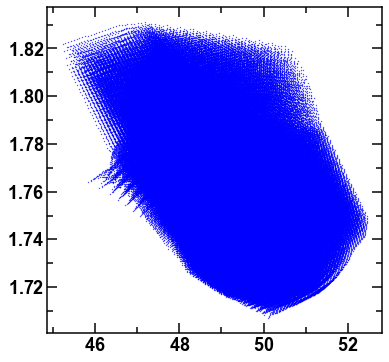

In [112]:
plt.scatter(patent.vd,patent.nd,s=0.1)
plt.show()

In [128]:
patent.to_csv('patent_'+save_name+'.csv',index=False)

In [143]:
family=['P2O5','B2O3','Al2O3','Li2O','ZnO','BaO','CaO','SrO','MgO','La2O3','Gd2O3']
output=['nd']
dfshow = nds[nds[family].sum(axis=1).between(99,101)][family+output]
mask = dfshow.astype(bool).sum(axis=1)==len(family)-2
# dfshow[mask]

,P2O5,B2O3,Al2O3,Li2O,ZnO,BaO,CaO,SrO,MgO,La2O3,Gd2O3,nd
1860,45.55,1.01,1.49,0.87,2.37,44.73,1.63,0.00,2.35,0.0,0.00,1.597978
1862,44.19,1.03,1.51,1.33,2.41,45.48,1.66,0.00,2.39,0.0,0.00,1.600326
1869,44.19,1.06,1.55,1.34,2.41,45.40,1.66,0.00,2.39,0.0,0.00,1.600217
1915,43.00,1.30,1.30,1.00,21.30,26.70,3.20,0.00,0.00,0.0,2.20,1.607587
1916,41.00,1.30,1.30,3.00,21.30,26.70,3.20,0.00,0.00,0.0,2.20,1.612158
1917,40.00,1.30,1.30,4.00,21.30,26.70,3.20,0.00,0.00,0.0,2.20,1.613642
1958,42.00,1.50,1.00,2.50,7.00,40.50,3.00,0.00,0.00,0.0,2.50,1.608318
1961,42.00,1.50,1.50,2.00,21.00,26.50,3.00,0.00,0.00,0.0,2.50,1.609584
1963,42.00,1.50,1.50,2.00,14.00,33.50,3.00,0.00,0.00,0.0,2.50,1.607880
2136,42.87,2.10,1.54,1.81,2.46,46.31,1.69,0.00,1.22,0.0,0.00,1.601807


In [144]:
stats=dfshow[mask].describe()
stats

,P2O5,B2O3,Al2O3,Li2O,ZnO,BaO,CaO,SrO,MgO,La2O3,Gd2O3,nd
count,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000
mean,43.989444,4.983889,2.396389,2.816389,5.006667,30.462778,4.128889,1.524722,3.355000,0.447222,0.871667,1.594075
std,4.356743,2.946303,1.182049,1.332051,7.004417,10.943664,3.161250,3.165431,2.486076,1.150524,1.369839,0.013942
min,35.240000,1.010000,0.300000,0.600000,0.000000,1.100000,0.000000,0.000000,0.000000,0.000000,0.000000,1.540781
25%,41.275000,1.950000,1.507500,1.692500,0.300000,25.600000,1.652500,0.000000,1.505000,0.000000,0.000000,1.586339
50%,44.190000,4.950000,2.425000,3.005000,2.410000,32.250000,3.200000,0.000000,3.340000,0.000000,0.000000,1.597730
75%,46.032500,6.550000,2.930000,3.955000,4.010000,36.915000,6.997500,0.000000,5.110000,0.000000,2.200000,1.603126
max,61.200000,11.140000,6.800000,5.000000,21.300000,46.310000,10.000000,8.670000,10.600000,5.600000,3.510000,1.613642


In [145]:
mins=list(dfshow[mask].min(axis=0).values)
maxs=list(dfshow[mask].max(axis=0).values)

In [157]:
delta=0.8
chemstr = []
for i in range(len(family)):
    chem = family[i].lower()
    chemstr.append(chem)
    if mins[i]-5 <= 0:
        code='for '+chem+' in '+'np.arange('+str(mins[i])+','+str(maxs[i])+','+str(delta)+'):'
    else:
        mini=mins[i]-5.
        maxi=maxs[i]+5.
        code='for '+chem+' in '+'np.arange('+str(mini)+','+str(maxi)+','+str(delta)+'):'
    print(code)

for p2o5 in np.arange(30.240000000000002,66.2,0.8):
for b2o3 in np.arange(1.01,11.14,0.8):
for al2o3 in np.arange(0.3,6.8,0.8):
for li2o in np.arange(0.6,5.0,0.8):
for zno in np.arange(0.0,21.3,0.8):
for bao in np.arange(1.1,46.31,0.8):
for cao in np.arange(0.0,10.0,0.8):
for sro in np.arange(0.0,8.67,0.8):
for mgo in np.arange(0.0,10.6,0.8):
for la2o3 in np.arange(0.0,5.6,0.8):
for gd2o3 in np.arange(0.0,3.51,0.8):


In [161]:
','.join(chemstr)

'p2o5,b2o3,al2o3,li2o,zno,bao,cao,sro,mgo,la2o3,gd2o3'

In [ ]:
for i in range(len(family)):
    if mins[i]-5 <= 0:
        for n in np.arange(mins[i],maxs[i]+5,0.5):
            save=[]
        

In [166]:
# family=['B2O3','Gd2O3', 'ZnO', 'La2O3', 'ZrO2']
family=['P2O5','B2O3','Al2O3','Li2O','ZnO','BaO','CaO','SrO','MgO','La2O3','Gd2O3']
take_composition = []
delta=2.5
for p2o5 in np.arange(30.24,66.2,delta):
    for b2o3 in np.arange(1.01,11.14,delta):
        for al2o3 in np.arange(0.3,6.8,delta):
            for li2o in np.arange(0.6,5.0,delta):
                for zno in np.arange(0.0,21.3,delta):
                    for bao in np.arange(1.1,46.31,delta):
                        for cao in np.arange(0.0,10.0,0.8):
                            for sro in np.arange(0.0,8.67,delta):
                                for mgo in np.arange(0.0,10.6,delta):
                                    for la2o3 in np.arange(0.0,5.6,delta):
                                        for gd2o3 in np.arange(0.0,3.51,delta):
                                            if 99.99 <= (p2o5+b2o3+al2o3+li2o+zno+bao+cao+sro+mgo+la2o3+gd2o3) <= 101:
                                                save=[p2o5,b2o3,al2o3,li2o,zno,bao,cao,sro,mgo,la2o3,gd2o3]
                                                take_composition.append(save)

In [167]:
len(take_composition)

2009922

In [168]:
save_name = '_'.join(family)

In [169]:
sample = pd.DataFrame(data=take_composition,columns=family)

In [173]:
synthetic.sum(axis=1).unique()

array([100.35, 100.45, 100.55, 100.65, 100.75, 100.45, 100.55, 100.65,
       100.75, 100.55, 100.65, 100.35, 100.45, 100.75, 100.35, 100.45,
       100.55, 100.65, 100.55, 100.75, 100.65, 100.35, 100.45, 100.75])

In [171]:
synthetic = pd.DataFrame(data=take_composition,columns=family)
mask = synthetic.sum(axis=1)>99.9
df_synthetic = synthetic[mask]
df_synthetic.shape

(2009922, 11)

In [ ]:
patentx_nd = pd.concat((pd.DataFrame(columns=nds.columns[:-1]),df_synthetic)).fillna(0)

patentx_vd = pd.concat((pd.DataFrame(columns=vds.columns[:-1]),df_synthetic)).fillna(0)

In [174]:
patentx_nd = pd.concat((pd.DataFrame(columns=nds.columns[:-1]),df_synthetic)).fillna(0)

patentx_vd = pd.concat((pd.DataFrame(columns=vds.columns[:-1]),df_synthetic)).fillna(0)

In [206]:
1-0.46

0.54

In [347]:
sampletcc['nd']=nsave
sampletcc['Vd']=vsave

3.13

In [11]:
tcc = [[56,15.54,3.39,3.38,0.32,15.78,2.72,0.33,0.92,0.57,1.05],
       [60.03,15.54,3.39,3.38,0.32,11.75,2.72,0.33,1,0.57,0.97],
       [57.07,16.82,3.31,2.38,0.0,13.75,3.72,0.53,0.8,0.47,1.15],
       [59.13,17.14,3.31,0.0,0.0,13.75,3.72,0.53,0.8,0.47,1.15],
       [59.13,20.86,3.13,0.0,0.0,13.75,0.0,0.53,0.8,0.47,1.15],
       [60.03,18.54,0.39,3.38,0.32,11.75,2.72,0.33,1,0.57,0.97]]

In [12]:
tcc = [[56,15.54,3.39,3.38,0.32,15.78,2.72,0.92,0.57,1.38],
       [60.03,15.54,3.39,3.38,0.32,11.75,3.05,1,0.57,0.97],
       [57.07,16.82,3.01,2.35,0.0,14.61,3.72,0.8,0.47,1.15],
       [59.33,17.14,3.31,0.0,0.0,13.75,3.72,1.13,0.47,1.15],
       [59.13,20.86,3.31,0.0,0.0,13.75,0.53,0.8,0.47,1.15],
       [60.03,18.54,0.39,3.38,0.32,11.75,2.72,1.33,0.57,0.97],
       [57.57,17.32,2.01,2.35,0.0,14.61,3.72,0.8,0.47,1.15],
       [57.57,17.32,2.51,2.35,0.0,14.11,3.72,0.8,0.47,1.15],
       [58.37,17.32,2.51,2.35,0.0,14.11,3.72,0.0,0.47,1.15],
       [60.78,21.54,2.39,0.38,0.32,9.90,2.72,1.40,0.57,0.00],
       [78.00,17.7,1.00,2.99,0.31,0.0,0.0,0.0,0.0,0.0],
       [77.31,17.7,1.00,3.99,0.0,0.0,0.0,0.0,0.0,0.0],
       [78.30,16.71,4.00,0.00,0.00,0.99,0.0,0.0,0.0,0.0]]

In [13]:
family2=['P2O5','B2O3','Al2O3','Li2O','ZnO','BaO','CaO','MgO','La2O3','Gd2O3']

In [14]:
sampletcc = pd.DataFrame(data=tcc,columns=family2)

In [ ]:
sampletcc

In [114]:
sampletcc.sum(axis=1)

0     100.0
1     100.0
2     100.0
3     100.0
4     100.0
5     100.0
6     100.0
7     100.0
8     100.0
9     100.0
10    100.0
11    100.0
12    100.0
dtype: float64

In [115]:
def one(onecomp_sample):
    onecomp=pd.concat((pd.DataFrame(columns=nds.columns[:-1]),onecomp_sample)).fillna(0)
    xn = torch.tensor(onecomp.values).float()

    mean_xn = xn.mean(dim=0, keepdim=True)
    stds_xn = xn.std(dim=0, keepdim=True)
    mask_xn = stds_xn<=0.0001
    stds_xn[mask_xn] = 1

    norm_xn = (xn - mean_xnds)/stds_xnds
    nd_patent = ((model_nd(norm_xn).detach().numpy())*op[0][1].stds[0][-1].numpy() + op[0][1].means[0][-1].numpy()).ravel()

    onecomp=pd.concat((pd.DataFrame(columns=vds.columns[:-1]),onecomp_sample)).fillna(0)
    xv = torch.tensor(onecomp.values).float()
    mean_xv = xv.mean(dim=0, keepdim=True)
    stds_xv = xv.std(dim=0, keepdim=True)
    mask_xv = stds_xv<=0.0001
    stds_xv[mask_xv] = 1
    #     norm_xn = (xn - op[0][1].means[0][:-1])/op[0][1].stds[0][:-1]
    #         norm_xv = (xv - mean_xv)/stds_xv
    norm_xv = (xv-mean_xvds)/stds_xvds
    vd_patent = ((model_vd(norm_xv).detach().numpy())*op1[0][0].stds[0][-1].numpy() + op1[0][0].means[0][-1].numpy()).ravel()
#     print(nd_patent,vd_patent)
    
    return nd_patent, vd_patent

In [116]:
nsave,vsave=one(sampletcc)

In [117]:
sampletcc['nd']=nsave
sampletcc['Vd']=vsave

In [118]:
sampletcc

,P2O5,B2O3,Al2O3,Li2O,ZnO,BaO,CaO,MgO,La2O3,Gd2O3,nd,Vd
0,56.00,15.54,3.39,3.38,0.32,15.78,2.72,0.92,0.57,1.38,1.559625,66.399651
1,60.03,15.54,3.39,3.38,0.32,11.75,3.05,1.00,0.57,0.97,1.551692,67.010773
2,57.07,16.82,3.01,2.35,0.00,14.61,3.72,0.80,0.47,1.15,1.557878,66.556412
3,59.33,17.14,3.31,0.00,0.00,13.75,3.72,1.13,0.47,1.15,1.554092,66.749527
4,59.13,20.86,3.31,0.00,0.00,13.75,0.53,0.80,0.47,1.15,1.548762,67.067886
5,60.03,18.54,0.39,3.38,0.32,11.75,2.72,1.33,0.57,0.97,1.552433,66.361961
6,57.57,17.32,2.01,2.35,0.00,14.61,3.72,0.80,0.47,1.15,1.557966,66.388199
7,57.57,17.32,2.51,2.35,0.00,14.11,3.72,0.80,0.47,1.15,1.557154,66.504974
8,58.37,17.32,2.51,2.35,0.00,14.11,3.72,0.00,0.47,1.15,1.556245,66.632309
9,60.78,21.54,2.39,0.38,0.32,9.90,2.72,1.40,0.57,0.00,1.545240,67.468903


In [21]:
sampletcc.to_csv('optical.csv',index=None)

In [19]:
cc = sampletcc[sampletcc.columns[:-2]]
cc[colsnew]

NameError: name 'colsnew' is not defined

In [429]:
colsnew = ravinder.columns[1:].tolist()

In [426]:
ravinder=pd.read_csv('patents_new.csv')
sampletcc[ravinder.columns[1:].tolist()]

,B2O3,Al2O3,MgO,CaO,BaO,Li2O,ZnO,La2O3,Gd2O3,P2O5
0,15.54,3.39,0.92,2.72,15.78,3.38,0.32,0.57,1.38,56.00
1,15.54,3.39,1.00,3.05,11.75,3.38,0.32,0.57,0.97,60.03
2,16.82,3.01,0.80,3.72,14.61,2.35,0.00,0.47,1.15,57.07
3,17.14,3.31,1.13,3.72,13.75,0.00,0.00,0.47,1.15,59.33
4,20.86,3.31,0.80,0.53,13.75,0.00,0.00,0.47,1.15,59.13
5,18.54,0.39,1.33,2.72,11.75,3.38,0.32,0.57,0.97,60.03
6,17.32,2.01,0.80,3.72,14.61,2.35,0.00,0.47,1.15,57.57
7,17.32,2.51,0.80,3.72,14.11,2.35,0.00,0.47,1.15,57.57
8,17.32,2.51,0.00,3.72,14.11,2.35,0.00,0.47,1.15,58.37
9,21.54,2.39,1.40,2.72,9.90,0.38,0.32,0.57,0.00,60.78


In [424]:
sampletcc[ravinder.columns[1:].tolist()].to_csv('pyggi_predict.csv',index=False)

In [175]:
xn = torch.tensor(patentx_nd.values).float()

mean_xn = xn.mean(dim=0, keepdim=True)
stds_xn = xn.std(dim=0, keepdim=True)
mask_xn = stds_xn<=0.0001
stds_xn[mask_xn] = 1

norm_xn = (xn - mean_xnds)/stds_xnds
nd_patent = ((model_nd(norm_xn).detach().numpy())*op[0][1].stds[0][-1].numpy() + op[0][1].means[0][-1].numpy()).ravel()


xv = torch.tensor(patentx_vd.values).float()
mean_xv = xv.mean(dim=0, keepdim=True)
stds_xv = xv.std(dim=0, keepdim=True)
mask_xv = stds_xv<=0.0001
stds_xv[mask_xv] = 1
#     norm_xn = (xn - op[0][1].means[0][:-1])/op[0][1].stds[0][:-1]
#         norm_xv = (xv - mean_xv)/stds_xv
norm_xv = (xv-mean_xvds)/stds_xvds
vd_patent = ((model_vd(norm_xv).detach().numpy())*op1[0][0].stds[0][-1].numpy() + op1[0][0].means[0][-1].numpy()).ravel()

In [176]:
patent = patentx_nd.copy()
patent['nd'] = nd_patent
patent['vd'] = vd_patent

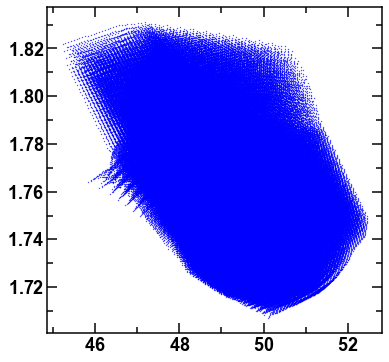

In [177]:
plt.scatter(patent.vd,patent.nd,s=0.1)
plt.show()

In [128]:
patent.to_csv('patent_'+save_name+'.csv',index=False)

In [27]:
pp = nds[family2+['nd']]
mask =pp.astype(bool).sum(axis=1)==10

s1 = pp[mask]
s1[s1[family2].sum(axis=1)==100]

,P2O5,B2O3,Al2O3,Li2O,ZnO,BaO,CaO,MgO,La2O3,Gd2O3,nd
1865,42.13,1.04,1.52,1.77,4.83,43.69,1.66,1.20,0.0,2.16,1.606321
1867,42.98,1.05,1.54,1.81,2.47,44.58,2.04,2.44,0.0,1.09,1.603302
2528,37.72,4.63,3.76,3.75,0.00,36.22,6.62,4.76,1.2,1.34,1.604816
2537,32.06,4.72,2.30,2.03,7.35,34.64,5.07,3.64,0.0,8.19,1.628201
2538,32.06,4.72,2.30,2.02,7.35,34.65,5.07,3.64,0.0,8.19,1.628220
2852,45.00,8.30,4.80,0.80,1.10,33.90,2.30,1.60,2.2,0.00,1.587903


In [30]:
pp = vds[family2+['Vd']]
mask =pp.astype(bool).sum(axis=1)==5
s1 = pp[mask]
s1[s1[family2].sum(axis=1)==100]

,P2O5,B2O3,Al2O3,Li2O,ZnO,BaO,CaO,MgO,La2O3,Gd2O3,Vd
721,67.00,0.0,0.00,3.00,0.0,15.0,0.00,0.0,15.0,0.0,63.741661
742,62.00,0.0,0.00,3.00,0.0,20.0,0.00,0.0,15.0,0.0,63.219643
1084,67.00,0.0,4.00,0.00,0.0,23.0,6.00,0.0,0.0,0.0,67.934181
1118,65.00,0.0,5.00,0.00,0.0,20.0,10.00,0.0,0.0,0.0,67.640488
1231,77.08,0.0,17.02,1.20,0.0,0.0,4.70,0.0,0.0,0.0,70.982780
1232,77.04,0.0,17.03,1.25,0.0,0.0,4.68,0.0,0.0,0.0,70.984268
2014,77.31,4.7,14.99,3.00,0.0,0.0,0.00,0.0,0.0,0.0,71.297806
2390,48.00,10.0,0.00,0.00,0.0,20.0,22.00,0.0,0.0,0.0,64.655235
3217,0.00,35.0,0.00,0.00,40.0,10.0,0.00,0.0,15.0,0.0,51.978931
3218,0.00,35.0,0.00,0.00,30.0,20.0,0.00,0.0,15.0,0.0,53.225082


In [35]:
family=['SiO2','Al2O3','B2O3','BaO','K2O','Na2O','TiO2']

tcc=[[34.8,   2.6,  15.57,  45.36, 0.8, 0.07, 0.8],
     [35.8,   1.4,  15.90,  45.7,  0.0, 0.90, 0.3],
     [34.0,   3.4,   15.5,  45.5,  0.8, 0.00, 0.8],
     [37.0,    2.,  16.10,  43.7,  0.5, 0.40, 0.3],
     [37.0,    2. , 16.10,  43.7,  0.4, 0.70, 0.1]]
pd.DataFrame(data=tcc,columns=family).to_csv('fam1_vals.csv')

In [36]:
family=['B2O3','La2O3','ZnO','SiO2','BaO','ZrO2']
tcc   =[[15.5,   60. , 0.4,  17.0 ,  0.6 , 6.5],
        [17.0,   60. , 0.4,  15.5 ,  0.6 , 6.5],
        [17.0,   60. , 0.4,  14.5 ,  0.5 , 7.6],
        [17.0,   60. , 0.5,  13.5 ,  0.4 , 8.6],
        [17.0,   60. , 0.5,  14.5 ,  0.4 , 7.6]]
pd.DataFrame(data=tcc,columns=family).to_csv('fam2_vals.csv')